#### Install all the dependencies

In [1]:
from docling.document_converter import DocumentConverter
import langgraph
import os
from dotenv import load_dotenv
 
docpath = os.path.join('..','app','uploads','state-of-the-union.pdf')
os.path.exists(docpath)

True

#### Parse the document using docling

In [2]:
doclingconverter =  DocumentConverter()
doc = doclingconverter.convert(source=docpath).document


d:\code\docuRAG\docuRAG-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Recursive chunking

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text = doc.export_to_text()
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=200,
    chunk_overlap=20,
    is_separator_regex=False,
    length_function=len,
)

recursive_text_chunks = text_splitter.create_documents([text])
print(recursive_text_chunks[20])
print(recursive_text_chunks[21])

Parameter `strict_text` has been deprecated and will be ignored.


page_content='Stand up. Welcome. Welcome, welcome, welcome. And they know how to fight.'
page_content='Mr. Prime Minister, welcome to NATO, the strongest military alliance the world has ever seen.'


#### Semantic chunking

In [5]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

text_splitter = SemanticChunker(OpenAIEmbeddings())

semantic_text = text_splitter.create_documents([text])
print(semantic_text[20])
print(semantic_text[21])


page_content='I'm not stopping there. My administration has proposed rules to make cable, travel, utilities and online ticket sellers tell you the total price up front so there are no surprises. It matters.'
page_content='It matters. And so does this: In November, my team began serious negotiations with a bipartisan group of senators. The result was a bipartisan bill with the toughest set of border security reforms we've ever seen. Oh, you don't think so? Oh, you don't like that bill, huh? That conservatives got together and said was a good bill?'


#### Our custom chunking

In [6]:
import re
from typing import List
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# PARAMETERS (you can change these)
similarity_threshold = 0.6
min_chunk_sentences = 3
max_chunk_sentences = 10
overlap = 1
chunking_method = 'semantic_chunking'

# Load model explicitly here
model = SentenceTransformer('all-MiniLM-L6-v2')

def preprocess(text: str) -> str:
    return re.sub(r'\s+', ' ', text).strip()

def split_paragraphs(text: str) -> List[str]:
    paragraphs = re.split(r'\n{2,}', text)
    return [p.strip() for p in paragraphs if p.strip()]

def split_sentences(text: str) -> List[str]:
    return [s.strip() for s in sent_tokenize(text) if s.strip()]

def compute_similarity(sentences: List[str]) -> List[float]:
    embeddings = model.encode(sentences)
    adjacent_similarities = [
        cosine_similarity([embeddings[i]], [embeddings[i + 1]])[0][0]
        for i in range(len(embeddings) - 1)
    ]
    return adjacent_similarities

def find_boundaries(adjacent_similarities: List[float], sentences: List[str]) -> List[int]:
    boundaries = [0]
    sentence_count = 0

    for i, sim in enumerate(adjacent_similarities, start=1):
        sentence_count += 1
        if (sim < similarity_threshold and sentence_count >= min_chunk_sentences) or (sentence_count >= max_chunk_sentences):
            boundaries.append(i)
            sentence_count = 0

    boundaries.append(len(sentences))
    return boundaries

def semantic_chunk(text: str) -> dict:
    text = preprocess(text)
    paragraphs = split_paragraphs(text)

    all_sentences = []
    para_boundaries = []
    count = 0
    for para in paragraphs:
        sents = split_sentences(para)
        all_sentences.extend(sents)
        count += len(sents)
        para_boundaries.append(count)

    if not all_sentences:
        return {"chunks": [], "chunking_method": chunking_method}

    sim_matrix = compute_similarity(all_sentences)
    boundaries = find_boundaries(sim_matrix, all_sentences)

    adjusted_boundaries = [boundaries[0]]
    for b in boundaries[1:-1]:
        close_paras = [pb for pb in para_boundaries if abs(pb - b) <= 2 and pb > adjusted_boundaries[-1]]
        if close_paras:
            adjusted_boundaries.append(min(close_paras))
        else:
            adjusted_boundaries.append(b)
    adjusted_boundaries.append(boundaries[-1])

    chunks = []
    for i in range(len(adjusted_boundaries) - 1):
        start = adjusted_boundaries[i]
        end = adjusted_boundaries[i + 1]
        if i > 0 and overlap > 0:
            start = max(start - overlap, 0)
        chunk_text = ' '.join(all_sentences[start:end])
        chunks.append(chunk_text)

    print("Chunking done")
    return chunks


custom_chunking_result = semantic_chunk(text)
print("chunk: ",custom_chunking_result[20])
print("chunk",custom_chunking_result[21])


Chunking done
chunk:  But they failed. America stood. America stood strong and democracy prevailed. We must be honest.
chunk We must be honest. The threat to democracy must be defended. My predecessor and some of you here seek to bury the truth about Jan. 6. I will not do that.


### Embedding Models

For embedding our chunks into embeddings we will use the 3 most popular embedding models:

- **text-embedding-3-small** by OpenaAI

- **all-MINILM-L6-v2** from HuggingFace

- **BAAI/bge-small-en-v1.5** from HuggingFace

let's format the chunks retrieved through chunkers.

In [7]:
recursive_text= [doc.page_content for doc in recursive_text_chunks] 
semantic_text_chunks = [doc.page_content for doc in semantic_text]  
custom_chunking = custom_chunking_result 

### Evaluation Strategy for Chunking and Embedding Comparison

To assess the effectiveness of different chunking and embedding combinations, we used the following evaluation approach:

- **Sampling:** For each chunking strategy, we randomly sampled 20 text chunks from the document collection.

- **Question Generation:** For each sampled chunk, we generated 5 different types of questions (short, detailed, direct, context-based, vague) using a large language model.

- **Retrieval and Scoring:** Each question was used to retrieve the top-k relevant chunks based on the embeddings generated by the chosen embedding model.

- **Accuracy Calculation:** Accuracy was computed as the fraction of questions where the original chunk was successfully retrieved within the top-k results.

- **Latency Measurement:** We recorded the total time taken for embedding, retrieval, and scoring to evaluate the efficiency of each strategy.

This method enabled a comprehensive comparison of accuracy and latency across multiple chunking and embedding model pairs.


In [8]:
from langchain.embeddings import HuggingFaceEmbeddings,HuggingFaceBgeEmbeddings
evaluation_pairs = [
    {
        "chunking_strategy": "recursive",
        "chunks": recursive_text,
        "embedding_model": OpenAIEmbeddings(model="text-embedding-3-small")
    },
    {
        "chunking_strategy": "recursive",
        "chunks": recursive_text,
        "embedding_model": HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    },
    {
        "chunking_strategy": "recursive",
        "chunks": recursive_text,
        "embedding_model": HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")
    },
    {
        "chunking_strategy": "semantic",
        "chunks": semantic_text_chunks,
        "embedding_model": OpenAIEmbeddings(model="text-embedding-3-small")
    },
    {
        "chunking_strategy": "semantic",
        "chunks": semantic_text_chunks,
        "embedding_model": HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    },
    {
        "chunking_strategy": "semantic",
        "chunks": semantic_text_chunks,
        "embedding_model": HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")
    },
    {
        "chunking_strategy": "custom",
        "chunks": custom_chunking_result,
        "embedding_model": OpenAIEmbeddings(model="text-embedding-3-small")
    },
    {
        "chunking_strategy": "custom",
        "chunks": custom_chunking_result,
        "embedding_model": HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    },
    {
        "chunking_strategy": "custom",
        "chunks": custom_chunking_result,
        "embedding_model": HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")
    }
]

C:\Users\Ritik\AppData\Local\Temp\ipykernel_17432\3543913697.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  "embedding_model": HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
C:\Users\Ritik\AppData\Local\Temp\ipykernel_17432\3543913697.py:18: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  "embedding_model": 

The functions **generate_questions_per_chunk**, **evaluate_overall_accuracy_and_latency** have been imported from the reportHelper.py file present in the report folder.

In [12]:
import sys
from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)

from report import reportHelper

for pair in evaluation_pairs:
    chunks = pair["chunks"]
    model = pair["embedding_model"]
    strategy = pair["chunking_strategy"]

    # Evaluate
    questions_by_chunk = reportHelper.generate_questions_per_chunk(chunks)

    accuracy, latency = reportHelper.evaluate_overall_accuracy_and_latency(
        questions_by_chunk=questions_by_chunk,
        all_chunks=chunks,
        embedding_model=model,
        k=3
    )

    print(f"Strategy: {strategy}, Model: {type(model).__name__}, Accuracy: {accuracy:.2%}, Latency: {latency:.3f}s")


Strategy: recursive, Model: OpenAIEmbeddings, Accuracy: 90.00%, Latency: 3.422s
Strategy: recursive, Model: HuggingFaceEmbeddings, Accuracy: 75.00%, Latency: 1.733s
Strategy: recursive, Model: HuggingFaceBgeEmbeddings, Accuracy: 73.00%, Latency: 3.564s
Strategy: semantic, Model: OpenAIEmbeddings, Accuracy: 89.00%, Latency: 2.216s
Strategy: semantic, Model: HuggingFaceEmbeddings, Accuracy: 79.00%, Latency: 0.999s
Strategy: semantic, Model: HuggingFaceBgeEmbeddings, Accuracy: 87.00%, Latency: 4.359s
Strategy: custom, Model: OpenAIEmbeddings, Accuracy: 87.00%, Latency: 3.154s
Strategy: custom, Model: HuggingFaceEmbeddings, Accuracy: 68.00%, Latency: 2.197s
Strategy: custom, Model: HuggingFaceBgeEmbeddings, Accuracy: 78.00%, Latency: 4.342s


#### Accuracy 

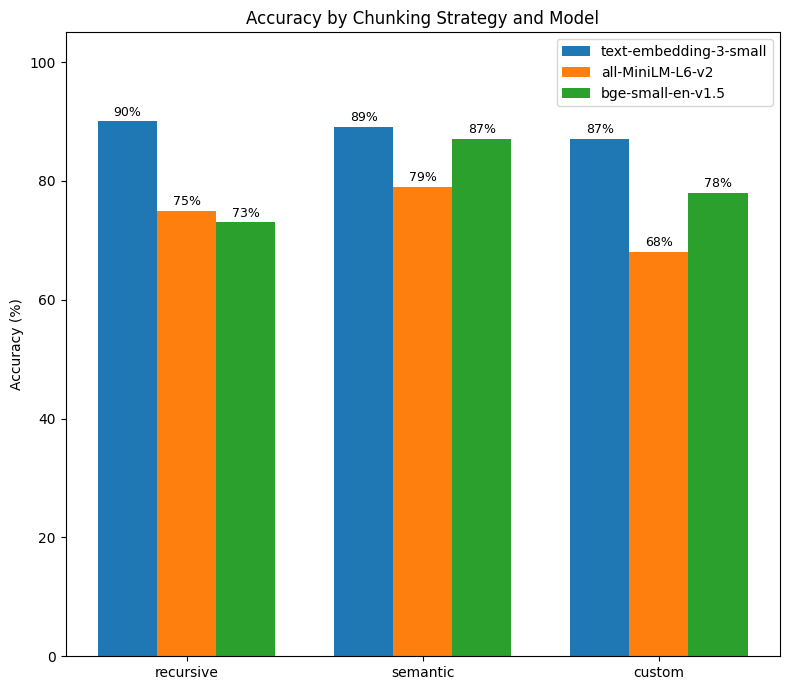

In [27]:
import matplotlib.pyplot as plt
import numpy as np

data = [
    ("recursive", "text-embedding-3-small", 90.0),
    ("recursive", "all-MiniLM-L6-v2", 75.0),
    ("recursive", "bge-small-en-v1.5", 73.0),
    ("semantic", "text-embedding-3-small", 89.0),
    ("semantic", "all-MiniLM-L6-v2", 79.0),
    ("semantic", "bge-small-en-v1.5", 87.0),
    ("custom", "text-embedding-3-small", 87.0),
    ("custom", "all-MiniLM-L6-v2", 68.0),
    ("custom", "bge-small-en-v1.5", 78.0),
]

strategies = ["recursive", "semantic", "custom"]
models = ["text-embedding-3-small", "all-MiniLM-L6-v2", "bge-small-en-v1.5"]
x = np.arange(len(strategies))
width = 0.25

plt.figure(figsize=(8, 7))

for i, model in enumerate(models):
    values = [d[2] for d in data if d[1] == model]
    bars = plt.bar(x + i * width, values, width, label=model)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{bar.get_height():.0f}%", ha='center', fontsize=9)

plt.ylabel("Accuracy (%)")
plt.title("Accuracy by Chunking Strategy and Model")
plt.xticks(x + width, strategies)
plt.ylim(0, 105)
plt.legend()
plt.tight_layout()
plt.show()


The highest retrieval accuracy (90%) was achieved using the recursive chunking strategy with the text-embedding-3-small model. Overall, OpenAI’s model consistently outperformed others 

across all chunking strategies. Among alternatives, BGE performed better than MiniLM for semantic and custom chunking. Custom chunks showed the most variation, with accuracy ranging from 

68% to 87%, highlighting the impact of embedding choice.

#### Latency

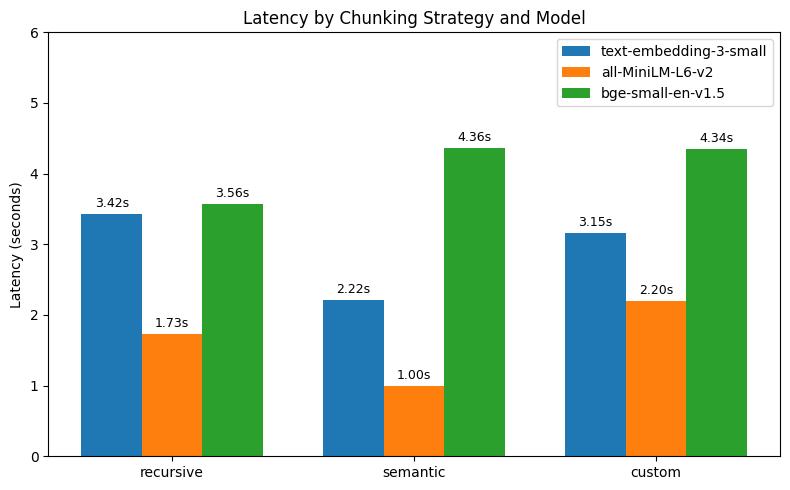

In [28]:
latency_data = [
    ("recursive", "text-embedding-3-small", 3.422),
    ("recursive", "all-MiniLM-L6-v2", 1.733),
    ("recursive", "bge-small-en-v1.5", 3.564),
    ("semantic", "text-embedding-3-small", 2.216),
    ("semantic", "all-MiniLM-L6-v2", 0.999),
    ("semantic", "bge-small-en-v1.5", 4.359),
    ("custom", "text-embedding-3-small", 3.154),
    ("custom", "all-MiniLM-L6-v2", 2.197),
    ("custom", "bge-small-en-v1.5", 4.342),
]

plt.figure(figsize=(8, 5))

for i, model in enumerate(models):
    values = [d[2] for d in latency_data if d[1] == model]
    bars = plt.bar(x + i * width, values, width, label=model)
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f"{bar.get_height():.2f}s", ha='center', fontsize=9)

plt.ylabel("Latency (seconds)")
plt.title("Latency by Chunking Strategy and Model")
plt.xticks(x + width, strategies)
plt.ylim(0, 6)
plt.legend()
plt.tight_layout()
plt.show()


Latency analysis revealed notable differences among embedding models. The all-MiniLM-L6-v2 consistently demonstrated the lowest latency, achieving sub-second performance (as low as 0.

999s with semantic chunking), making it ideal for low-latency applications. In contrast, bge-small-en-v1.5 showed the highest latency, particularly with semantic and custom chunking (up 

to 4.359s), indicating heavier computational overhead. text-embedding-3-small maintained moderate latency across all strategies (ranging from 2.2s to 3.4s), offering a balanced trade-off 

between performance and responsiveness.

#### Agent Graph

Our LangGraph agent uses a stateful, modular graph to handle complex user queries. The flow begins with a router node that directs requests to either RAG retrieval, direct answering, or 

interview booking. The rag_lookup node optionally routes to web_search if external data is needed. All paths eventually converge at the answer node, ensuring consistent final responses. 

The agent is extensible and ideal for task-specific logic like bookings or search-enhanced Q&A.

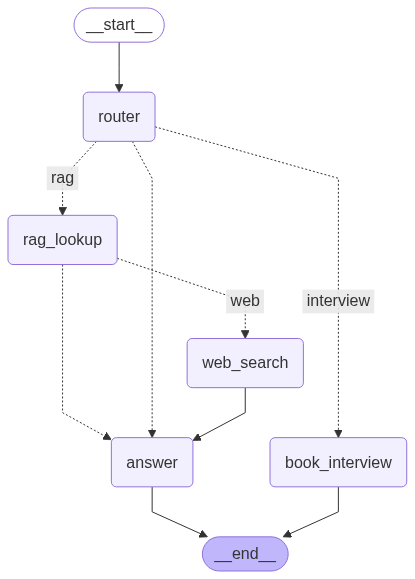

In [33]:
from langgraph.graph import StateGraph, END
from app.services.agent import AgentState
from langchain_core.tools import tool
from typing import Literal, Optional
from pydantic import BaseModel

@tool
def rag_search_tool(query: str) -> str:
    """RAG tool search"""
    pass

@tool
def web_search_tool(query: str) -> str:
    """Fetch up-to-date web information using TavilySearch."""
    # res = tavily.invoke({"query": query})
    # return "\n".join(result["content"] for result in res["results"])
    pass

class RouteDecision(BaseModel):
    route: Literal["rag", "answer", "end"]
    reply: Optional[str] = None


class RagJudge(BaseModel):
    sufficient: bool

def _router_node( state: AgentState) -> AgentState:
            # q = state["messages"][-1].content
            # decision: RouteDecision = llm_router.invoke([
            #     SystemMessage(content="You are a routing agent. Decide whether to answer from memory (RAG), ask LLM directly (answer), or end the conversation."),
            #     HumanMessage(content=q)
            # ])
            # new_state = {**state, "route": decision.route}
            # if decision.route == "end":
            #     new_state["messages"].append(AIMessage(content=decision.reply or "Goodbye!"))
            # return new_state
            pass

def _rag_node( state: AgentState) -> AgentState:
            # q = state["messages"][-1].content
            # chunks = rag_search_tool.invoke({"query": q})
            # prompt = f"Question: {q}\nDocs: {chunks[:300]}…"
            # verdict: RagJudge = llm_judge.invoke([HumanMessage(content=prompt)])
            # return {**state, "rag": chunks, "route": "answer" if verdict.sufficient else "web"}
            pass

def _web_node( state: AgentState) -> AgentState:
            # q = state["messages"][-1].content
            # web_snippets = web_search_tool.invoke({"query": q})
            # return {**state, "web": web_snippets, "route": "answer"}
            pass

def _answer_node( state: AgentState) -> AgentState:
            # context = ""
            # if state.get("rag"):
            #     context += f"Knowledge:\n{state['rag']}\n\n"
            # if state.get("web"):
            #     context += f"Web:\n{state['web']}\n\n"

            # user_query = state["messages"][-1].content
            # final_answer = llm_answer.invoke([
            #     ("system", f"You are an assistant. Use the provided context to answer.\n{context}"),
            #     ("user", user_query)])
        pass

def _booking_node(state:AgentState) -> AgentState:
        #for booking interview and sending email
        pass

def from_router(state: AgentState) -> str:
        # The router node sets `route` in the state
        return state.get("route", "end")

def after_rag(state: AgentState) -> str:
        # After rag node, route based on `route` key
        return state.get("route", "answer")

agent_graph = StateGraph(AgentState)
        
agent_graph.add_node("router", _router_node)
agent_graph.add_node("rag_lookup", _rag_node)
agent_graph.add_node("web_search", _web_node)
agent_graph.add_node("answer", _answer_node)
agent_graph.add_node("book_interview", _booking_node)

agent_graph.set_entry_point("router")

agent_graph.add_conditional_edges("router", from_router, {
            "rag": "rag_lookup",
            "answer": "answer",   
            "answer": "answer",     
            "interview":"book_interview"
        })

agent_graph.add_conditional_edges("rag_lookup", after_rag, {
            "web": "web_search",
            "answer": "answer"
        })
agent_graph.add_edge("web_search", "answer")
agent_graph.add_edge("book_interview",END)
agent_graph.add_edge("answer", END)
agent_graph.compile()